In [41]:
import re
import os
from razdel import sentenize
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm

In [3]:
with open('/Users/alinamaksimova/Desktop/работа/shadows of mind/dataset/Mikhail Vrubel/letters/1872_10_dd_l_AVrubel.txt') as file:
    text = file.read()

In [4]:
def clean_text(text: str) -> str:
    text = text.replace('\n', ' ')
    cleaned_text = re.sub(r'\s+', ' ', text).strip()

    return cleaned_text

cleaned_text = clean_text(text)

In [5]:
sentences = []
for substring in list(sentenize(cleaned_text)):
    sentences.append(substring.text)

print(sentences)

['М. Л. ВРУБЕЛЬ — А. А. ВРУБЕЛЬ I Одесса.', 'Октябрь 1872 Тысячу, тысячу раз завидую тебе, Милая Анюта, что ты в Петербурге: понимаете ли вы, сударыня, что значит для человека, сидящего в этой тре- нроклятой Одессе, намозолившего глаза, глядя на всех ее дурацких народцев, читать письма петербуржца, от которых так, кажется, и веет свежестью Невы.', 'Раblеu, madame!', '(ты еще, вероятно, не забыла, кто так выражается).^ еще тысячу раз повторяю, что задыхался от зависти, когда читал ваше письмо, в котором, без сомнения, тьма достоинств, о, тьма неотъемлемых достоинств, и только один крошечный недостаток, что хотя от него и веет Петербургом, так как оно написано в Петербурге, на петербургской бумаге, петербургскими чернилами, но в строках не видно и тени Петербурга.', 'Помилуйте сударыня, неужели у вас так мало впечатлительности, восприимчивости и т. д. (об остальном справьтесь в любой теории словесности или в какой- нибудь критической статье Белинского), что он не произвел на вас никакого

In [ ]:
model_checkpoint = 'j-hartmann/emotion-english-distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

In [ ]:
if torch.cuda.is_available():
    model.cuda()

def estimate_sentiment(messages: list) -> list:
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            weights = [-1, 0, 1] + [0] * (len(proba) - 3)
            # sentiment_out.append(proba.dot([-1, 0, 1]))
            sentiment_out.append(proba.dot(weights))
    return sentiment_out

sentiments = estimate_sentiment(sentences)

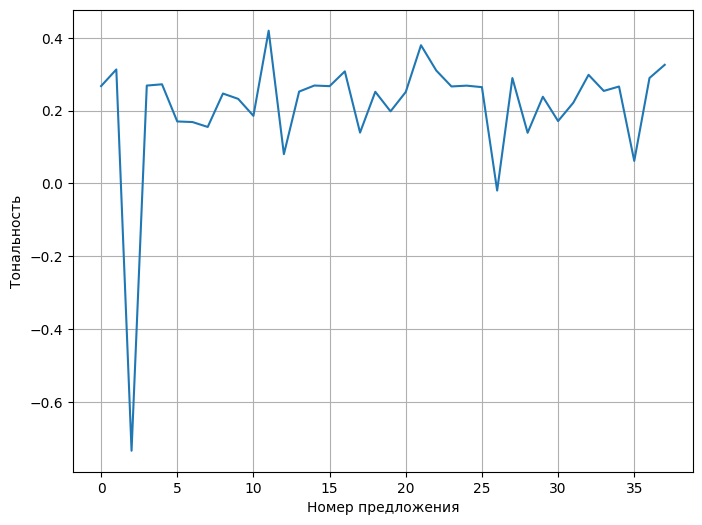

In [18]:
plt.figure(figsize=(8,6))
plt.plot(sentiments)
plt.xlabel('Номер предложения')
plt.ylabel('Тональность')
plt.grid()

In [14]:
# filtered_sentiments = savgol_filter(sentiments, window_length=len(sentiments)//15, polyorder=0)

def ensemble_filter(data: list, n_filters=100, polyorder=0, **savgol_args) -> list:
    """
    Применяет ансамблевый фильтр к входным данным

    Parameters:
    data (list): входной массив данных
    n_filters (int, optional): число фильтров участвующих в сглаживании
    """
    filt = 0
    start = len(data)//10
    stop = len(data)//4
    step = (stop-start)//n_filters
    if step == 0:
        step = 1
    # Варьируем размер окна и усредняем результат
    for window_size in range(start, stop, step):
        res = savgol_filter(data, window_length=window_size, polyorder=polyorder, **savgol_args)
        filt += res
    return filt/n_filters

filtered_sentiments = ensemble_filter(sentiments, polyorder=0)

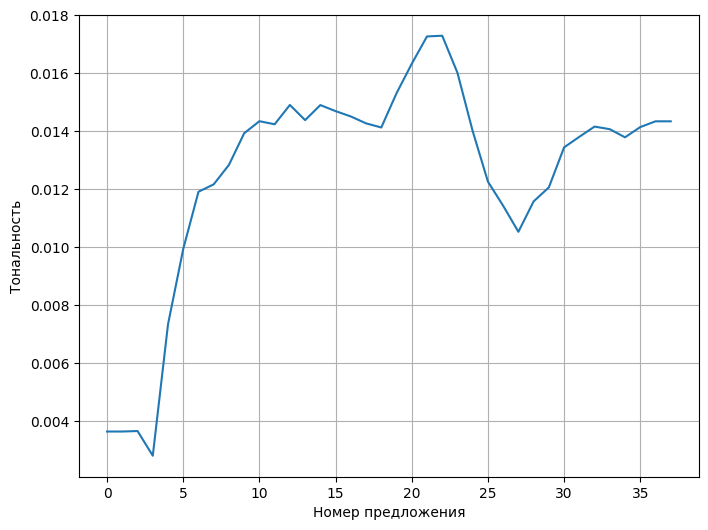

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(filtered_sentiments)
plt.xlabel('Номер предложения')
plt.ylabel('Тональность')
plt.grid()

In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_checkpoint = 'j-hartmann/emotion-english-distilroberta-base'
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# if torch.cuda.is_available():
#     model.cuda()

def estimate_sentiment(messages: list) -> float:
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            weights = [-1, 0, 1] + [0] * (len(proba) - 3)
            sentiment_out.append(proba.dot(weights))

    overall_sentiment = sum(sentiment_out) / len(sentiment_out) if sentiment_out else 0
    return overall_sentiment

# Пример использования
sentences = ["I am happy", "I am sad", "I feel neutral"]
overall_sentiment = estimate_sentiment(sentences)
print(f"Общее настроение: {overall_sentiment}")

Общее настроение: -0.13471237321694693


In [ ]:
folder_path = '/Users/alinamaksimova/Desktop/работа/shadows of mind/dataset/Mikhail Vrubel/letters'
files = os.listdir('/Users/alinamaksimova/Desktop/работа/shadows of mind/dataset/Mikhail Vrubel/letters')

In [40]:
def estimate_sentiment(messages: list) -> float:
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            weights = [-1, 0, 1] + [0] * (len(proba) - 3)
            sentiment_out.append(proba.dot(weights))
    
    overall_sentiment = sum(sentiment_out) / len(sentiment_out) if sentiment_out else 0
    return overall_sentiment

In [60]:
results = {}

for i in tqdm(files):
    if '.DS_Store' not in i:
        if 'yyyy' not in i:
            # print(i)
            filepath = os.path.join(folder_path, i)
            # print(filepath)
            with open(filepath, 'r') as file:
                text = file.read()
            # print(text)
            cleaned_text = clean_text(text)
            
            sentences = []
            for substring in list(sentenize(cleaned_text)):
                sentences.append(substring.text)
                
            overall_sentiment = estimate_sentiment(sentences)
            results[i] = overall_sentiment

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


In [61]:
from pprint import pprint

pprint(results)

{'1872_10_dd_l_AVrubel.txt': 0.2109559084239759,
 '1873_08_09_l_AVrubel.txt': 0.21402122179667155,
 '1873_mm_dd_l_AVrubel1.txt': 0.2491791358119563,
 '1874_mm_dd_l_AVrubel.txt': 0.24061116705770078,
 '1874_mm_dd_l_AVrubel1.txt': 0.13663506805896758,
 '1875_02_02_l_AVrubel.txt': 0.1885899779471484,
 '1875_07_26_l_Ber.txt': 0.2381580760081609,
 '1876_04_06_l_parents.txt': 0.17600634886372474,
 '1879_04_23_l_AVrubel.txt': 0.15374351575456816,
 '1879_mm_dd_l_AVrubel.txt': 0.21986711025238037,
 '1883_01_06_l_AVrubel.txt': 0.22463636966638786,
 '1883_01_13_l_AVrubel.txt': 0.2052158129711946,
 '1883_04_dd_l_AVrubel.txt': 0.2341633690642072,
 '1883_06_11_l_pparents.txt': 0.23566537847121558,
 '1883_mm_dd_l_AVrubel.txt': 0.2525355833949465,
 '1883_mm_dd_l_AVrubel1.txt': 0.261383271071969,
 '1884_01_dd_l_AVrubel.txt': 0.23424573586537287,
 '1884_11_dd_l_AVrubel.txt': 0.20001176638262613,
 '1884_12_31_l_Prahov.txt': 0.22564944066107273,
 '1884_mm_dd_l_Prahov.txt': 0.2707132756710052,
 '1885_01_04

In [64]:
from collections import defaultdict
import statistics

by_year = defaultdict(list)
for filename, sentiment in results.items():
    year = filename[:4]
    by_year[year].append(sentiment)

# Шаг 3: считаем среднее по каждому году
average_by_year = {year: statistics.mean(values) for year, values in by_year.items()}

# # Вывод
# for year in sorted(average_by_year):
#     print(f"{year}: {average_by_year[year]:.4f}")

In [68]:
average_by_year

{'1892': 0.20330368878231161,
 '1896': 0.20397809718609292,
 '1887': 0.20883909794918173,
 '1900': 0.24132503726416166,
 '1893': 0.2230929133566943,
 '1903': 0.20960878394544125,
 '1875': 0.21337402697765467,
 '1899': 0.20210570222919896,
 '1889': 0.23085024625890785,
 '1902': 0.19331096496187797,
 '1890': 0.22034954737104914,
 '1885': 0.20866716656693576,
 '1888': 0.227373677291076,
 '1884': 0.23265505464501923,
 '1904': 0.25068779392884327,
 '1906': 0.23173660243905725,
 '1883': 0.23559996410665346,
 '1891': 0.24373759650267085,
 '1886': 0.23479016960917654,
 '1873': 0.23160017880431394,
 '1901': 0.21949517602721852,
 '1872': 0.2109559084239759,
 '1874': 0.18862311755833416,
 '1894': 0.23273965567350388,
 '1898': 0.24034650686477857,
 '1876': 0.17600634886372474,
 '1879': 0.18680531300347425}

In [72]:
sorted_by_year = sorted(average_by_year.items())
sorted_by_year

[('1872', 0.2109559084239759),
 ('1873', 0.23160017880431394),
 ('1874', 0.18862311755833416),
 ('1875', 0.21337402697765467),
 ('1876', 0.17600634886372474),
 ('1879', 0.18680531300347425),
 ('1883', 0.23559996410665346),
 ('1884', 0.23265505464501923),
 ('1885', 0.20866716656693576),
 ('1886', 0.23479016960917654),
 ('1887', 0.20883909794918173),
 ('1888', 0.227373677291076),
 ('1889', 0.23085024625890785),
 ('1890', 0.22034954737104914),
 ('1891', 0.24373759650267085),
 ('1892', 0.20330368878231161),
 ('1893', 0.2230929133566943),
 ('1894', 0.23273965567350388),
 ('1896', 0.20397809718609292),
 ('1898', 0.24034650686477857),
 ('1899', 0.20210570222919896),
 ('1900', 0.24132503726416166),
 ('1901', 0.21949517602721852),
 ('1902', 0.19331096496187797),
 ('1903', 0.20960878394544125),
 ('1904', 0.25068779392884327),
 ('1906', 0.23173660243905725)]

In [74]:
sent = []
year = []
for i in sorted_by_year:
    # print(i)
    sent.append(i[1])
    year.append(i[0])

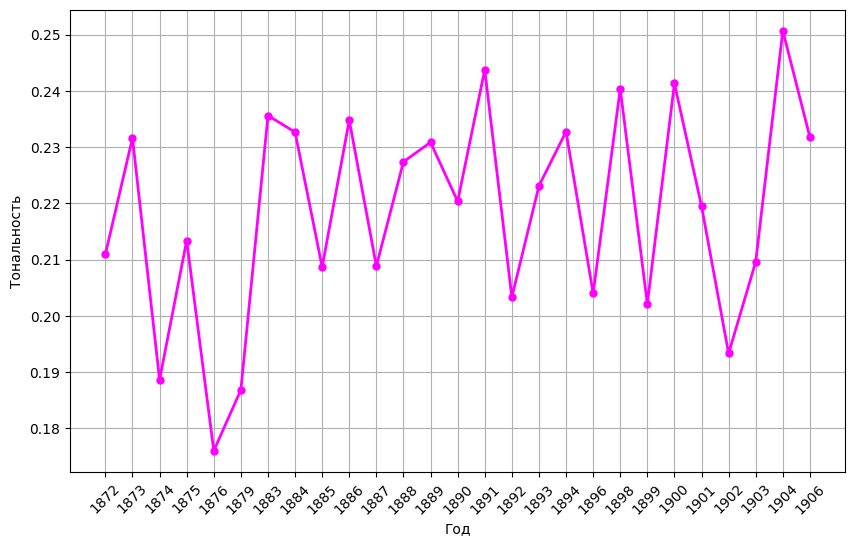

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(year, sent, color='magenta', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Год')
plt.ylabel('Тональность')
plt.xticks(rotation=45)
plt.grid()

In [ ]:
filtered_results = ensemble_filter(sent, polyorder=0)

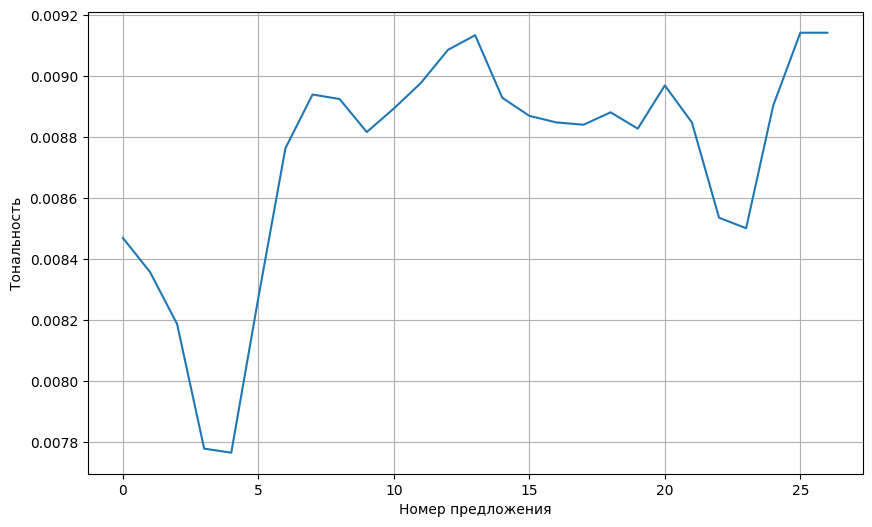

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_results)
plt.xlabel('Номер предложения')
plt.ylabel('Тональность')
plt.grid()